# Two Tunable Qubits + One Tunable Coupler: Engtangling gates

### Imports

In [ ]:
#!pip install c3-toolset
#!pip install matplotlib
#!pip install plotly
#!pip install nbformat --upgrade

In [1]:
import os
import tempfile
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.eager.context import num_gpus
import tensorflow_probability as tfp
# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils
from c3.optimizers.optimalcontrol import OptimalControl

#%matplotlib widget
import plotly.graph_objects as go
from utilities_functions import *
from plotting import *

2022-05-03 11:12:40.365310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 11:12:40.365359: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Define Qubits and coupler

Define Qubits, Coupler, Drives and Couplings

In [2]:
qubit_levels = [3, 3, 3, 3, 3]
qubit_frequencies = [3.944e9, 3.7147e9, 3.9116e9, 4.3906e9, 3.5379e9]
anharmonicities = [-220e6, -210e6, -220e6, -210e6, -220e6]
t1 = [60e-6, 30e-6, 60e-6, 30e-6, 60e-6]
t2star = [66e-6, 5e-6, 66e-6, 5e-6, 66e-6]
qubit_temp = [50e-3, 50e-3, 50e-3, 50e-3, 50e-3]
transmon_phi = [0.0, 0.0, 0.0, 0.0, 0.0]
transmon_phi_0 = [10.0, 10.0, 10.0, 10.0, 10.0]
transmon_d = [0.0, 0.0, 0.0, 0.0, 0.0]


qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1,
                      t2star, transmon_phi, transmon_phi_0, transmon_d, qubit_temp)

coupler_names = ["C1", "C2", "C4", "C5"]
coupler_levels = [2, 2, 2, 2]
frequency_coupler = [7.04297e9, 6.86082e9, 7.02573e9, 7.06186e9]
anharmonicity_coupler = [-90e6, -90e6, -90e6, -90e6]
t1_coupler = [10e-6, 10e-6, 10e-6, 10e-6]
t2star_coupler = [1e-6, 1e-6, 1e-6, 1e-6]
coupler_temp = [50e-3, 50e-3, 50e-3, 50e-3]
phi_coupler = [3.0227, 3.0227, 3.0227, 3.0227]
phi_0_coupler = [10.0, 10.0, 10.0, 10.0]
d_coupler = [0.0, 0.0, 0.0, 0.0]

couplers = createCouplers(coupler_names, coupler_levels, frequency_coupler, anharmonicity_coupler, t1_coupler,
                      t2star_coupler, phi_coupler, phi_0_coupler, d_coupler, coupler_temp)

# Couple the qubits to the coupler
coupling_strengths = {"Q1-C1": 72.5e6, 
                      "Q3-C1": 71.5e6,
                      "Q2-C2": 72.5e6,
                      "Q3-C2": 71.5e6,
                      "Q4-C4": 72.5e6,
                      "Q3-C4": 71.5e6,
                      "Q5-C5": 72.5e6,
                      "Q3-C5": 71.5e6}

couplings = []
for i in coupling_strengths:
        sys1, sys2 = i.split("-")
        couplings.append(
            chip.Coupling(
                name=i,
                desc="Coupling",
                comment=f"Coupling between {sys1} and {sys2}",
                connected=[sys1, sys2],
                strength=Qty(
                    value=coupling_strengths[i],
                    min_val=-1 * 1e3,
                    max_val=200e6,
                    unit="Hz 2pi",
                ),
                hamiltonian_func=hamiltonians.int_XX,
            )
        )


drives = createDrives(qubits)

2022-05-03 11:12:42.394581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-03 11:12:42.394625: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-03 11:12:42.394652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (daqc-okteto-7fc5fd65dd-klwxf): /proc/driver/nvidia/version does not exist
2022-05-03 11:12:42.394930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Define the model using the Qubits, Couplers, Drives and Couplings

In [3]:
model = Mdl(
    qubits + couplers,
    drives + couplings,
    max_excitations=5
)
model.set_lindbladian(False)
model.set_dressed(False)

/usr/src/c3/c3/c3/model.py:384: UserWarning: C3 Warning: Some states are overly dressed, trying to recover...29 states, 309 is lowest failed state
  warnings.warn(


Generator

In [4]:
sim_res = 100e9
awg_res = 2e9
v2hz = 1e9

chain = ["LO", "AWG", "DigitalToAnalog", "Response", "Mixer", "VoltsToHertz"]
chains = {f"{d.name}": chain for d in drives}
chains["Q1"] = ["AWG", "DigitalToAnalog", "Response"]
chains["Q2"] = ["AWG", "DigitalToAnalog", "Response"]
chains["C1"] = ["AWG", "DigitalToAnalog", "Response"]

generator = Gnr(
    devices={
        "LO": devices.LO(name="lo", resolution=sim_res, outputs=1),
        "AWG": devices.AWG(name="awg", resolution=awg_res, outputs=1),
        "DigitalToAnalog": devices.DigitalToAnalog(
            name="dac", resolution=sim_res, inputs=1, outputs=1
        ),
        "Response": devices.Response(
            name="resp",
            rise_time=Qty(value=0.3e-9, min_val=0.05e-9, max_val=0.6e-9, unit="s"),
            resolution=sim_res,
            inputs=1,
            outputs=1,
        ),
        "Mixer": devices.Mixer(name="mixer", inputs=2, outputs=1),
        "VoltsToHertz": devices.VoltsToHertz(
            name="V_to_Hz",
            V_to_Hz=Qty(value=1e9, min_val=0.9e9, max_val=1.1e9, unit="Hz/V"),
            inputs=1,
            outputs=1,
        ),
        "fluxbias":devices.FluxTuning(
            name="fluxbias",
            inputs=1,
            outputs=1,
            params={
                "phi_0":Qty(value=10.0, min_val=9.0, max_val=11.0, unit="Wb"),
                "phi":Qty(value=0.0, min_val=0.0, max_val=5.0, unit="Hz 2pi"),
                "omega_0":Qty(value=7.172e9, min_val=6e9, max_val=10e9, unit="Hz 2pi"),
                "anhar":Qty(value=-250e6, min_val=-380e6, max_val=-120e6, unit="Hz 2pi"),
                "d":Qty(value=0, min_val=-0.324, max_val=0.396, unit="")
            }
        )
    },
    chains=chains,
)
generator.devices["AWG"].enable_drag_2()

In [5]:
generator.chains

{'d1': ['LO', 'AWG', 'DigitalToAnalog', 'Response', 'Mixer', 'VoltsToHertz'],
 'd2': ['LO', 'AWG', 'DigitalToAnalog', 'Response', 'Mixer', 'VoltsToHertz'],
 'd3': ['LO', 'AWG', 'DigitalToAnalog', 'Response', 'Mixer', 'VoltsToHertz'],
 'd4': ['LO', 'AWG', 'DigitalToAnalog', 'Response', 'Mixer', 'VoltsToHertz'],
 'd5': ['LO', 'AWG', 'DigitalToAnalog', 'Response', 'Mixer', 'VoltsToHertz'],
 'Q1': ['AWG', 'DigitalToAnalog', 'Response'],
 'Q2': ['AWG', 'DigitalToAnalog', 'Response'],
 'C1': ['AWG', 'DigitalToAnalog', 'Response']}

Define pulses and carriers used for applying the gates

In [6]:
t_final = 10e-9
sideband = 50e6
nodrive_env = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=        t_final,
            min_val=0.5 * t_final,
            max_val=1.5 * t_final,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)


params_flux = {
        "amp": Qty(
            value=2.0,
            min_val=0.1,
            max_val=5.0,
            unit="V"
        ),
        "t_up": Qty(
            value=2.0e-9,
            min_val=0.1e-9,
            max_val=5.0e-9,
            unit="s"
        ),
        "t_down": Qty(
            value=t_final + 0.01e-9,
            min_val=0.1e-9,
            max_val=t_final + 1.0e-9,
            unit="s"
        ),
        "risefall": Qty(
            value=1.0e-9,
            min_val=0.1e-9,
            max_val=5.0e-9,
            unit="s"
        ),
        'xy_angle': Qty(
            value=0.0,
            min_val=-0.5 * np.pi,
            max_val=2.5 * np.pi,
            unit='rad'
        ),
        'freq_offset': Qty(
            value=-sideband - 3e6 ,
            min_val=-56 * 1e6 ,
            max_val=-52 * 1e6 ,
            unit='Hz 2pi'
        ),
        'delta': Qty(
            value=-1,
            min_val=-5,
            max_val=3,
            unit=""
        ),
        't_final': Qty(
            value=t_final,
            min_val=0.5 * t_final,
            max_val=1.5 * t_final,
            unit="s"
        )
}

gauss_params = {
    'amp': Qty(value=0.0, min_val=0.0, max_val=3, unit="V"),
    't_final': Qty(value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"),
    'sigma': Qty(value=t_final / 4, min_val=t_final / 8, max_val=t_final / 2, unit="s"),
    'xy_angle': Qty(value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit='rad'),
    'freq_offset': Qty(value=-sideband - 3e6, min_val=-56 * 1e6, max_val=-52 * 1e6, unit='Hz 2pi'),
    'delta': Qty(value=-1, min_val=-5, max_val=3, unit="")
}


flux_pulse = pulse.Envelope(
                name = "flux",
                params = params_flux,
                shape = envelopes.flattop
)

gaussian_pulse = pulse.Envelope(
    name="gauss",
    desc="Gaussian envelope",
    params=gauss_params,
    shape=envelopes.gaussian_nonorm
)

qubit_freqs = model.get_qubit_freqs()
carriers = createCarriers(qubit_freqs[:2], sideband)
carrier_coupler = createCarriers([qubit_freqs[-1]],sideband)[0]

Plot the variation of energy with external flux to find out the parameters for gate

In [7]:
def PlotAvoidedCrossingDiagram(flux_range, c_flux, q1_flux, q2_flux, tune_coupler, tune_q1, tune_q2):    
    model.set_dressed(True)
    model.update_model()
    
    c1.params["phi"] = Qty(value=c_flux, min_val=0.0, max_val=5.0, unit="Wb")
    qubits[0].params["phi"] = Qty(value=q1_flux, min_val=0.0, max_val=5.0, unit="Wb")
    qubits[1].params["phi"] = Qty(value=q2_flux, min_val=0.0, max_val=5.0, unit="Wb")
    model.update_model()

    states = [(1,0,0),(0,1,0),(0,0,1)]
    state_labels = model.get_state_indeces(states)
    energies = [[] for i in range(len(states))]
    freq_coupler_arr = []

    for i in flux_range:
        if tune_coupler:
            c1.params["phi"] = Qty(value=i, min_val=0.0, max_val=5.0, unit="Wb")
        elif tune_q1:
            qubits[0].params["phi"] = Qty(value=i, min_val=0.0, max_val=5.0, unit="Wb")
        elif tune_q2:
            qubits[1].params["phi"] = Qty(value=i, min_val=0.0, max_val=5.0, unit="Wb")
        else:
            print("Choose which component to tune")
            return 0
        
        model.update_model()
        eigen_energies = model.eigenframe.numpy()
        freq_coupler_arr.append(c1.get_freq()/(2*np.pi*1e9))
        for j in range(len(states)):
            energies[j].append(eigen_energies[state_labels[j]]/(2*np.pi*1e9))

    fig = go.Figure()
    for i in range(len(states)):
        fig.add_trace(go.Scatter(x=flux_range, y = energies[i], name = str(states[i]), mode = "lines"))
    fig.show()

    #plt.plot(flux_range, freq_coupler_arr)

    c1.params["phi"] = Qty(value=0.0, min_val=0.0, max_val=5.0, unit="Wb")
    qubits[0].params["phi"] = Qty(value=0.0, min_val=0.0, max_val=5.0, unit="Wb")
    qubits[1].params["phi"] = Qty(value=0.0, min_val=0.0, max_val=5.0, unit="Wb")
    model.update_model()

    model.set_dressed(False)
    model.update_model()

"""
PlotAvoidedCrossingDiagram(
    flux_range = np.linspace(0.0, 4.0, 100), 
    c_flux = 3.0465, 
    q1_flux = 1.2401, 
    q2_flux = 0.0, 
    tune_coupler = False, 
    tune_q1 = False, 
    tune_q2 = True
)
"""

'\nPlotAvoidedCrossingDiagram(\n    flux_range = np.linspace(0.0, 4.0, 100), \n    c_flux = 3.0465, \n    q1_flux = 1.2401, \n    q2_flux = 0.0, \n    tune_coupler = False, \n    tune_q1 = False, \n    tune_q2 = True\n)\n'

In [8]:
print("Qubit1 Frequency =", qubits[0].get_freq(phi_sig=1.2401).numpy()/(2*np.pi*1e9))
print("Qubit2 Frequency =", qubits[1].get_freq(phi_sig=0.0).numpy()/(2*np.pi*1e9))
print("Coupler Frequency =", c1.get_freq(phi_sig=3.0465).numpy()/(2*np.pi*1e9))


Qubit1 Frequency = (3.7933515742199235+0j)
Qubit2 Frequency = (3.7147+0j)


NameError: name 'c1' is not defined

Define the Gate using these parameters

In [13]:
qubit1_pulse = copy.deepcopy(gaussian_pulse)
qubit1_pulse.params["amp"] = Qty(value=0.0, min_val=0.0, max_val=5.0, unit="V")

qubit2_pulse = copy.deepcopy(gaussian_pulse)
qubit2_pulse.params["amp"] = Qty(value=0.0, min_val=0.0, max_val=5.0, unit="V")

qubit1_fluxpulse = copy.deepcopy(flux_pulse)
qubit1_fluxpulse.params["amp"] = Qty(value=1.2401, min_val=0.1, max_val=5.0, unit="V")
qubit1_fluxcarrier = copy.deepcopy(carriers[0])
qubit1_fluxcarrier.params["freq"] = Qty(value=0, min_val=0, max_val=8e9, unit="Hz 2pi")

qubit2_fluxpulse = copy.deepcopy(flux_pulse)
qubit2_fluxpulse.params["amp"] = Qty(value=0.0, min_val=0.0, max_val=5.0, unit="V")
qubit2_fluxcarrier = copy.deepcopy(carriers[1])
qubit2_fluxcarrier.params["freq"] = Qty(value=0, min_val=0, max_val=8e9, unit="Hz 2pi")


coupler_fluxpulse = copy.deepcopy(flux_pulse)
coupler_fluxpulse.params["amp"] = Qty(value=3.0465, min_val=0.1, max_val=5.0, unit="V")
coupler_fluxcarrier = copy.deepcopy(carrier_coupler)
coupler_fluxcarrier.params["freq"] = Qty(value=0, min_val=0, max_val=8e9, unit="Hz 2pi")

iswap = gates.Instruction(
    name = "iswap", targets = [0, 1], t_start = 0.0, t_end = t_final, channels=["d1", "d2"]
)

iswap.add_component(qubit1_pulse, "d1")
iswap.add_component(copy.deepcopy(carriers[0]), "d1")

iswap.add_component(qubit2_pulse, "d2")
iswap.add_component(copy.deepcopy(carriers[1]), "d2")

#iswap.add_component(qubit1_fluxpulse, "Q1")
#iswap.add_component(qubit2_fluxpulse, "Q2")
#iswap.add_component(coupler_fluxpulse,"C1")


two_qubit_gates = [iswap]

Define the experiment and compute the unitaries

In [14]:
model.max_excitations

5

In [15]:
parameter_map = PMap(instructions=two_qubit_gates, model=model, generator=generator)
#parameter_map.load_values("pw99.8.txt")
exp = Exp(pmap=parameter_map)

model.set_dressed(False)
model.use_FR = False
exp.use_control_fields = True 
exp.propagate_batch_size = 1

exp.set_opt_gates(['iswap[0, 1]'])

In [17]:
unitaries = exp.compute_propagators()

2022-05-03 11:33:16.796774: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 115333632000 exceeds 10% of free system memory.
2022-05-03 11:33:59.458456: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 483729408000 exceeds 10% of free system memory.


In [ ]:
plotComplexMatrix(unitaries['iswap[0, 1]'])

In [ ]:
#exp.write_config("DAQC_two_qubit_gates.hjson")

/usr/src/app/plotting.py:369: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


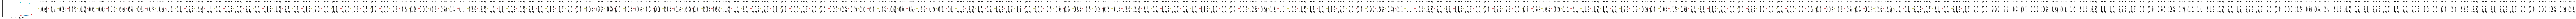

/usr/src/app/plotting.py:369: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [18]:
psi_init = [[0] * model.tot_dim]
psi_init[0][9] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['iswap[0, 1]']
plotPopulation(exp, init_state, sequence, usePlotly=False)
plotPopulation(exp, init_state, sequence, usePlotly=False, filename="iswap_gate.png")

In [ ]:
exp.write_config("DAQC_two_qubit_gates.hjson")
parameter_map.store_values("Two_qubit_gate.c3log")

### Ideal gate

In [ ]:
from qutip import *
import numpy as np
Nq1 = 3
Nq2 = 3
Nc = 3

Ideal_gate = np.array(tensor(qeye(Nq1), qeye(Nq2), qeye(Nc)) + 1j *tensor(basis(Nq1,1),basis(Nq2,0), basis(Nc,0))*tensor(basis(Nq1,0),basis(Nq2,1), basis(Nc,0)).dag() + 1j*tensor(basis(Nq1,0),basis(Nq2,1), basis(Nc,0))*tensor(basis(Nq1,1),basis(Nq2,0), basis(Nc,0)).dag() - tensor(basis(Nq1,1),basis(Nq2,0), basis(Nc,0))*tensor(basis(Nq1,1),basis(Nq2,0), basis(Nc,0)).dag() - tensor(basis(Nq1,0),basis(Nq2,1), basis(Nc,0))*tensor(basis(Nq1,0),basis(Nq2,1), basis(Nc,0)).dag()) 
print(Ideal_gate)
np.savetxt("ideal_gate.csv", Ideal_gate, delimiter=",")

### Optimisation

In [ ]:
opt_gates = [iswap.get_key()]
parameter_map.set_opt_map([
    [(iswap.get_key(), "Q1", "flux", "amp")],
    [(iswap.get_key(), "Q1", "flux", "t_up")],
    [(iswap.get_key(), "Q1", "flux", "t_down")],
    [(iswap.get_key(), "Q1", "flux", "risefall")],
    [(iswap.get_key(), "Q1", "flux", "xy_angle")],
    [(iswap.get_key(), "Q1", "flux", "freq_offset")],
    [(iswap.get_key(), "Q1", "flux", "delta")],

    [(iswap.get_key(), "Q2", "flux", "amp")],
    [(iswap.get_key(), "Q2", "flux", "t_up")],
    [(iswap.get_key(), "Q2", "flux", "t_down")],
    [(iswap.get_key(), "Q2", "flux", "risefall")],
    [(iswap.get_key(), "Q2", "flux", "xy_angle")],
    [(iswap.get_key(), "Q2", "flux", "freq_offset")],
    [(iswap.get_key(), "Q2", "flux", "delta")],

    [(iswap.get_key(), "C1", "flux", "amp")],
    [(iswap.get_key(), "C1", "flux", "t_up")],
    [(iswap.get_key(), "C1", "flux", "t_down")],
    [(iswap.get_key(), "C1", "flux", "risefall")],
    [(iswap.get_key(), "C1", "flux", "xy_angle")],
    [(iswap.get_key(), "C1", "flux", "freq_offset")],
    [(iswap.get_key(), "C1", "flux", "delta")],

    [(iswap.get_key(), "d1", "gauss", "amp")],
    [(iswap.get_key(), "d1", "gauss", "sigma")],
    [(iswap.get_key(), "d1", "gauss", "xy_angle")],
    [(iswap.get_key(), "d1", "gauss", "freq_offset")],
    [(iswap.get_key(), "d1", "gauss", "delta")],

    [(iswap.get_key(), "d2", "gauss", "amp")],
    [(iswap.get_key(), "d2", "gauss", "sigma")],
    [(iswap.get_key(), "d2", "gauss", "xy_angle")],
    [(iswap.get_key(), "d2", "gauss", "freq_offset")],
    [(iswap.get_key(), "d2", "gauss", "delta")],
])


parameter_map.print_parameters()

opt = OptimalControl(
    dir_path="./output",
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=["Q1", "C1", "Q2"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun": 20},
    run_name="iswap_trial"
)
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)

In [ ]:
opt.optimize_controls()
opt.current_best_goal

In [ ]:
plotPopulation(exp, init_state, sequence, usePlotly=False)

In [ ]:
parameter_map.print_parameters()

In [ ]:
ts = np.linspace(0, t_final, 10000)
parameter_map.load_values("best_point_open_loop_iswap.txt")

pmap_dict = parameter_map.asdict()
Q1_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["d1"]["gauss"]
Q2_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["d2"]["gauss"]
Q1_flux_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["Q1"]["flux"]
Q2_flux_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["Q2"]["flux"]
C1_flux_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["C1"]["flux"]


#Q1pulse_carrier = pmap_dict["rx90p[0]"]["drive_channels"]["d1"]["carrier"]
#Q2pulse_carrier = pmap_dict["rx90p[0]"]["drive_channels"]["d2"]["carrier"]

Q1pulse_shape = Q1_pulse.shape(ts, Q1_pulse.params)
#Q1pulse_shape = Q1pulse_shape * Q1_pulse.params["amp"]
Q2pulse_shape = Q2_pulse.shape(ts, Q2_pulse.params)
#Q2pulse_shape = Q2pulse_shape * Q2_pulse.params["amp"]


Q1_flux_pulse_shape = Q1_flux_pulse.shape(ts, Q1_flux_pulse.params)
#Q1_flux_pulse_shape = Q1_flux_pulse_shape * Q1_flux_pulse.params["amp"]
Q2_flux_pulse_shape = Q2_flux_pulse.shape(ts, Q2_flux_pulse.params)
#Q2_flux_pulse_shape = Q2_flux_pulse_shape * Q2_flux_pulse.params["amp"]
C1_flux_pulse_shape = C1_flux_pulse.shape(ts, C1_flux_pulse.params)
#C1_flux_pulse_shape = C1_flux_pulse_shape * C1_flux_pulse.params["amp"]


plt.figure(dpi=100)
plt.plot(ts, Q1pulse_shape, label="Qubit 1 Pulse")
plt.plot(ts, Q2pulse_shape, label="Qubit 2 Pulse")
plt.plot(ts, Q1_flux_pulse_shape, label="Qubit 1 Flux Pulse")
plt.plot(ts, Q2_flux_pulse_shape, label="Qubit 2 Flux Pulse")
plt.plot(ts, C1_flux_pulse_shape, label="Coupler Flux Pulse")

plt.legend()
plt.xlabel("Time (in seconds)")
plt.ylabel("Amplitude")
plt.savefig("Two_qubit_iswap_gate_pulse_shape.png")

## Trying PWC pulses

In [ ]:
t_final = 50e-9
ts = np.linspace(0, t_final, 100)
exp.read_config("DAQC_two_qubit_gates_50ns.hjson")
parameter_map = exp.pmap
model = parameter_map.model
parameter_map.load_values("best_point_open_loop_iswap.txt")
pmap_dict = parameter_map.asdict()
Q1_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["d1"]["gauss"]
Q2_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["d2"]["gauss"]
Q1_flux_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["Q1"]["flux"]
Q2_flux_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["Q2"]["flux"]
C1_flux_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["C1"]["flux"]


Q1_pulse_carrier = pmap_dict['iswap[0, 1]']["drive_channels"]["d1"]["carrier"]
Q2_pulse_carrier = pmap_dict['iswap[0, 1]']["drive_channels"]["d2"]["carrier"]

Q1_pulse_shape = Q1_pulse.shape(ts, Q1_pulse.params)
#Q1_pulse_shape = Q1_pulse_shape * Q1_pulse.params["amp"]
Q2_pulse_shape = Q2_pulse.shape(ts, Q2_pulse.params)
#Q2_pulse_shape = Q2_pulse_shape * Q2_pulse.params["amp"]


Q1_flux_pulse_shape = Q1_flux_pulse.shape(ts, Q1_flux_pulse.params)
#Q1_flux_pulse_shape = Q1_flux_pulse_shape * Q1_flux_pulse.params["amp"]
Q2_flux_pulse_shape = Q2_flux_pulse.shape(ts, Q2_flux_pulse.params)
#Q2_flux_pulse_shape = Q2_flux_pulse_shape * Q2_flux_pulse.params["amp"]
C1_flux_pulse_shape = C1_flux_pulse.shape(ts, C1_flux_pulse.params)
#C1_flux_pulse_shape = C1_flux_pulse_shape * C1_flux_pulse.params["amp"]


Q1_pulse_pwc_params = {
    'amp': Qty(value=Q1_pulse.params["amp"], min_val=0.0, max_val=5, unit="V"),
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "inphase": Qty(value=Q1_pulse_shape, min_val=0.0, max_val=5.0, unit=""),
    "t_final": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "xy_angle": Qty(value=Q1_pulse.params["xy_angle"], min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"),
    "freq_offset": Qty(value=Q1_pulse.params["freq_offset"],min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(Q1_pulse.params["delta"],min_val=-5,max_val=3,unit="")
}


Q1_pwc_pulse = pulse.Envelope(
    name="pwc_pulse",
    desc="PWC pulse for Qubit 1",
    params=Q1_pulse_pwc_params,
    shape=envelopes.pwc_shape
)

Q2_pulse_pwc_params = {
    'amp': Qty(value=Q2_pulse.params["amp"], min_val=0.0, max_val=5, unit="V"),
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "inphase": Qty(value=Q2_pulse_shape, min_val=0.0, max_val=5.0, unit=""),
    "t_final": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "xy_angle": Qty(value=Q2_pulse.params["xy_angle"], min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"),
    "freq_offset": Qty(value=Q2_pulse.params["freq_offset"],min_val=-56 * 1e6,max_val=0,unit="Hz 2pi"),
    "delta": Qty(Q2_pulse.params["delta"],min_val=-5,max_val=3,unit="")
}


Q2_pwc_pulse = pulse.Envelope(
    name="pwc_pulse",
    desc="PWC pulse for Qubit 2",
    params=Q2_pulse_pwc_params,
    shape=envelopes.pwc_shape
)

Q1_flux_pulse_pwc_params = {
    'amp': Qty(value=Q1_flux_pulse.params["amp"], min_val=0.0, max_val=5, unit="V"),
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "inphase": Qty(value=Q1_flux_pulse_shape, min_val=0.0, max_val=5.0, unit=""),
    "t_final": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "xy_angle": Qty(value=Q1_flux_pulse.params["xy_angle"], min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"),
    "freq_offset": Qty(value=Q1_flux_pulse.params["freq_offset"],min_val=-56 * 1e6,max_val=0,unit="Hz 2pi"),
    "delta": Qty(Q1_flux_pulse.params["delta"],min_val=-5,max_val=3,unit="")
}


Q1_flux_pwc_pulse = pulse.Envelope(
    name="pwc_pulse",
    desc="PWC Flux pulse for Qubit 1",
    params=Q1_flux_pulse_pwc_params,
    shape=envelopes.pwc_shape
)


Q2_flux_pulse_pwc_params = {
    'amp': Qty(value=Q2_flux_pulse.params["amp"], min_val=0.0, max_val=5, unit="V"),
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "inphase": Qty(value=Q2_flux_pulse_shape, min_val=0.0, max_val=5.0, unit=""),
    "t_final": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "xy_angle": Qty(value=Q2_flux_pulse.params["xy_angle"], min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"),
    "freq_offset": Qty(value=Q2_flux_pulse.params["freq_offset"],min_val=-56 * 1e6,max_val=0,unit="Hz 2pi"),
    "delta": Qty(Q2_flux_pulse.params["delta"],min_val=-5,max_val=3,unit="")
}


Q2_flux_pwc_pulse = pulse.Envelope(
    name="pwc_pulse",
    desc="PWC Flux pulse for Qubit 2",
    params=Q2_flux_pulse_pwc_params,
    shape=envelopes.pwc_shape
)

C1_flux_pulse_pwc_params = {
    'amp': Qty(value=C1_flux_pulse.params["amp"], min_val=0.0, max_val=5, unit="V"),
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "inphase": Qty(value=C1_flux_pulse_shape, min_val=0.0, max_val=5.0, unit=""),
    "t_final": Qty(value=t_final, min_val=1e-9, max_val=t_final+10e-9, unit="s"),
    "xy_angle": Qty(value=C1_flux_pulse.params["xy_angle"], min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"),
    "freq_offset": Qty(value=C1_flux_pulse.params["freq_offset"],min_val=-56 * 1e6,max_val=0,unit="Hz 2pi"),
    "delta": Qty(C1_flux_pulse.params["delta"],min_val=-5,max_val=3,unit="")
}


C1_flux_pwc_pulse = pulse.Envelope(
    name="pwc_pulse",
    desc="PWC Flux pulse for Coupler",
    params=C1_flux_pulse_pwc_params,
    shape=envelopes.pwc_shape
)

iswap = gates.Instruction(
    name = "iswap", targets = [0, 1], t_start = 0.0, t_end = t_final, channels=["Q1", "Q2", "C1", "d1", "d2"]
)

iswap.add_component(Q1_pwc_pulse, "d1")
iswap.add_component(Q1_pulse_carrier, "d1")

iswap.add_component(Q2_pwc_pulse, "d2")
iswap.add_component(Q2_pulse_carrier, "d2")

iswap.add_component(Q1_flux_pwc_pulse, "Q1")

iswap.add_component(Q2_flux_pwc_pulse, "Q2")

iswap.add_component(C1_flux_pwc_pulse,"C1")


two_qubit_gates = [iswap]

plt.plot(ts, Q1_pulse_shape, label="Qubit 1 Pulse")
plt.plot(ts, Q2_pulse_shape, label="Qubit 2 Pulse")
plt.plot(ts, Q1_flux_pulse_shape, label="Qubit 1 Flux Pulse")
plt.plot(ts, Q2_flux_pulse_shape, label="Qubit 2 Flux Pulse")
plt.plot(ts, C1_flux_pulse_shape, label="Coupler Flux Pulse")

In [ ]:
generator = parameter_map.generator
parameter_map = PMap(instructions=two_qubit_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)


model.set_dressed(False)
model.use_FR = False
exp.use_control_fields = False 

exp.set_opt_gates(['iswap[0, 1]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
psi_init[0][9] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['iswap[0, 1]']
plotPopulation(exp, init_state, sequence, usePlotly=False)#, filename="Before_opt_iswap_50ns.png")


In [ ]:
plotComplexMatrix(unitaries['iswap[0, 1]'])
plotComplexMatrix(tf_utils.tf_project_to_comp(unitaries["iswap[0, 1]"], dims=(3,3,3), index=[0, 1]))
M = tf_utils.tf_project_to_comp(unitaries["iswap[0, 1]"], dims=(3,3,3), index=[0, 1])
print(M)
print(np.angle(M))

In [ ]:
exp = Exp()
exp.read_config("DAQC_iswap_pwc.hjson")
parameter_map = exp.pmap
model = parameter_map.model
parameter_map.load_values("best_point_open_loop_pwc.txt")

generator = parameter_map.generator
#parameter_map = PMap(instructions=two_qubit_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)


model.set_dressed(False)
model.use_FR = False
exp.use_control_fields = False 

exp.set_opt_gates(['iswap[0, 1]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
psi_init[0][9] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['iswap[0, 1]']
plotPopulation(exp, init_state, sequence, usePlotly=False)#, filename="Before_opt_iswap_50ns.png")


In [ ]:
plotComplexMatrix(unitaries['iswap[0, 1]'])

In [ ]:
t_final =50e-9
ts = np.linspace(0, t_final, 10000)
parameter_map.load_values("best_pwc_99.95.txt")

pmap_dict = parameter_map.asdict()
Q1_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["d1"]["pwc_pulse"]
Q2_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["d2"]["pwc_pulse"]
Q1_flux_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["Q1"]["pwc_pulse"]
Q2_flux_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["Q2"]["pwc_pulse"]
C1_flux_pulse = pmap_dict['iswap[0, 1]']["drive_channels"]["C1"]["pwc_pulse"]


#Q1pulse_carrier = pmap_dict["rx90p[0]"]["drive_channels"]["d1"]["carrier"]
#Q2pulse_carrier = pmap_dict["rx90p[0]"]["drive_channels"]["d2"]["carrier"]

Q1pulse_shape = Q1_pulse.shape(ts, Q1_pulse.params)
#Q1pulse_shape = Q1pulse_shape * Q1_pulse.params["amp"]
Q2pulse_shape = Q2_pulse.shape(ts, Q2_pulse.params)
#Q2pulse_shape = Q2pulse_shape * Q2_pulse.params["amp"]


Q1_flux_pulse_shape = Q1_flux_pulse.shape(ts, Q1_flux_pulse.params)
#Q1_flux_pulse_shape = Q1_flux_pulse_shape * Q1_flux_pulse.params["amp"]
Q2_flux_pulse_shape = Q2_flux_pulse.shape(ts, Q2_flux_pulse.params)
#Q2_flux_pulse_shape = Q2_flux_pulse_shape * Q2_flux_pulse.params["amp"]
C1_flux_pulse_shape = C1_flux_pulse.shape(ts, C1_flux_pulse.params)
#C1_flux_pulse_shape = C1_flux_pulse_shape * C1_flux_pulse.params["amp"]


plt.figure(dpi=100)
plt.plot(ts, Q1pulse_shape, label="Qubit 1 Pulse")
plt.plot(ts, Q2pulse_shape, label="Qubit 2 Pulse")
plt.plot(ts, Q1_flux_pulse_shape, label="Qubit 1 Flux Pulse")
plt.plot(ts, Q2_flux_pulse_shape, label="Qubit 2 Flux Pulse")
plt.plot(ts, C1_flux_pulse_shape, label="Coupler Flux Pulse")

plt.legend()
plt.xlabel("Time (in seconds)")
plt.ylabel("Amplitude")
#plt.savefig("Two_qubit_iswap_gate_pulse_shape.png")

In [ ]:
plotComplexMatrix(tf_utils.tf_project_to_comp(unitaries["iswap[0, 1]"], dims=(3,3,3), index=[0, 1]))

In [ ]:
M = tf_utils.tf_project_to_comp(unitaries["iswap[0, 1]"], dims=(3,3,3), index=[0, 1])
print(M)

In [ ]:
np.angle(M)/0.45

In [ ]:
4.53309163/(2*np.pi) * 360 

In [ ]:
import random
import sys
import scipy as sc
M = np.array([[random.random() for e in range(4000)] for e in range(4000)], dtype=np.complex128)
M = tf.constant(M, dtype=tf.complex128)
sys.getsizeof(M)/1024/1024

In [ ]:
tf.linalg.expm(M)

In [ ]:
M